# Histograms of time-mean surface temperature

## Import the libraries

In [1]:
# Data analysis and viz libraries
import aeolus.plot as aplt
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
# Local modules
import mypaths
from names import names
from commons import MODELS
import const_ben1_hab1 as const
from plot_func import (
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    figsave,
)

In [3]:
def extract_sfc_temp(ds, model_key, case, const):
    """Extract surface temperature from a THAI dataset."""
    model_names = getattr(names, model_key.lower())
    out = ds[model_names.t_sfc]
    if model_key == "ROCKE3D":
        out = out.copy() + const.t_melt  # convert from degC to K
    return out

In [4]:
plt.style.use("paper.mplstyle")

## Load the data

Load the time-averaged data previously preprocessed.

In [5]:
THAI_cases = ["Hab1", "Hab2"]

In [6]:
# Load data
datasets = {}  # Create an empty dictionary to store all data
# for each of the THAI cases, create a nested directory for models
for THAI_case in THAI_cases:
    datasets[THAI_case] = {}
    for model_key in MODELS.keys():
        datasets[THAI_case][model_key] = xr.open_dataset(
            mypaths.datadir / model_key / f"{THAI_case}_regridded_time_mean_{model_key}.nc"
        )

In [7]:
bin_step = 10
bins = np.arange(170, 321, bin_step)
bin_mid = (bins[:-1] + bins[1:]) * 0.5
t_sfc_step = abs(bins - const.t_melt).max()

Saved to ../plots/Hab1_Hab2__hist__t_sfc_weighted.png


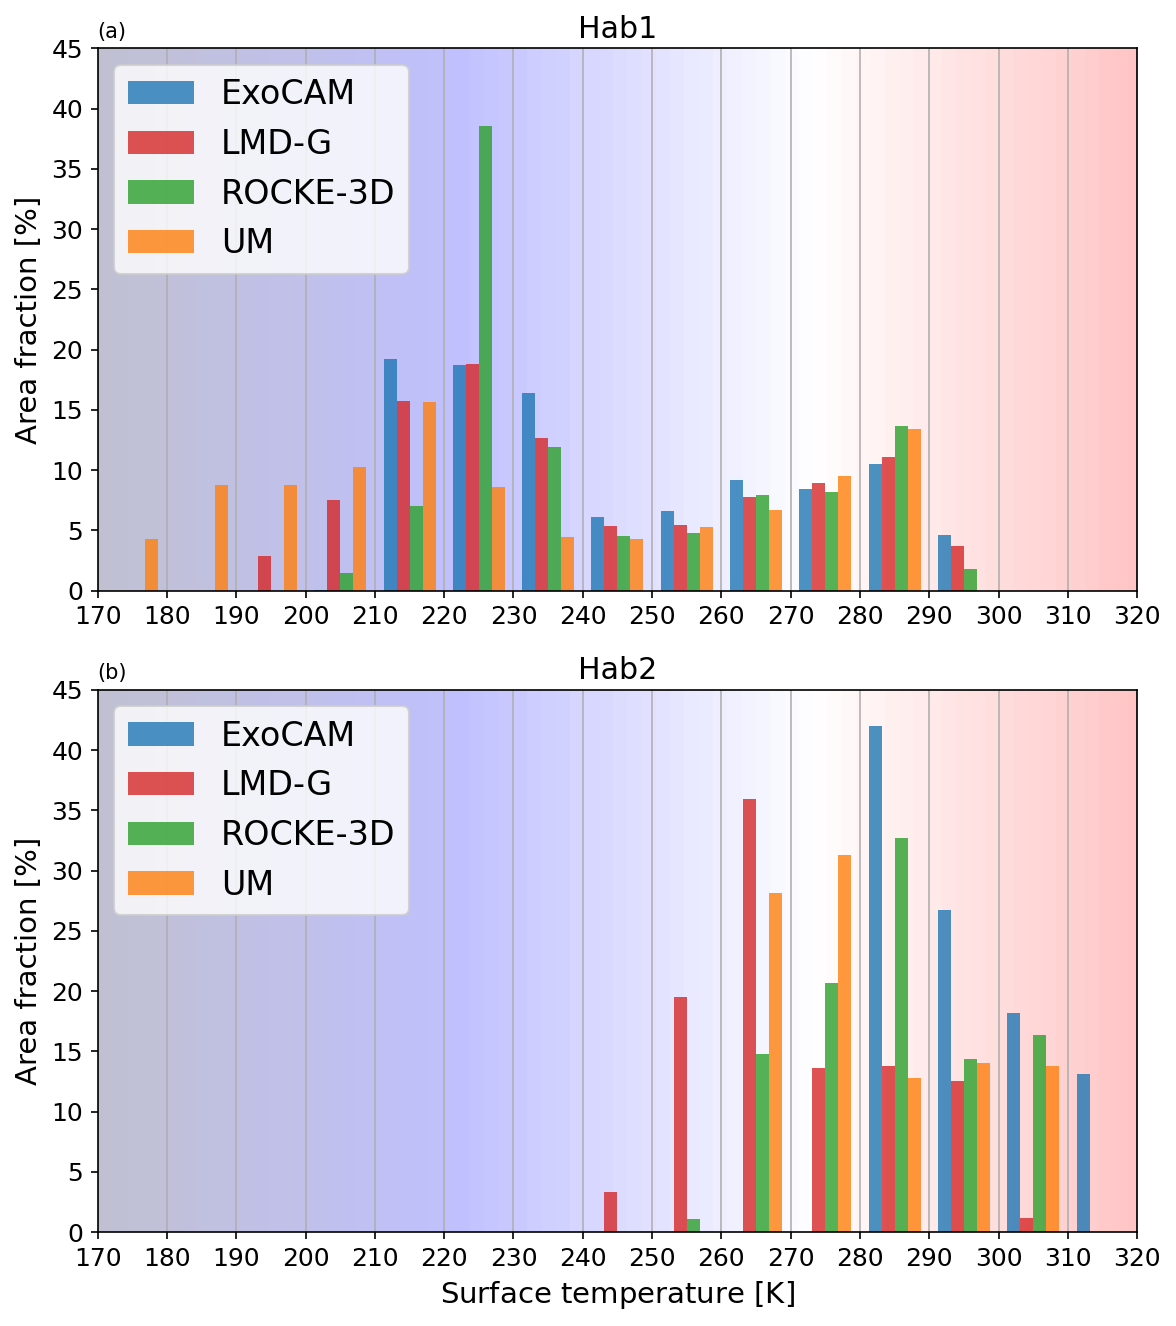

In [8]:
ncols = 1
nrows = 2

width = 0.75 * bin_step / len(MODELS)

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 8, nrows * 4.5))
iletters = aplt.subplot_label_generator()
for THAI_case, ax in zip(THAI_cases, axs.flat):
    ax.set_title(f"({next(iletters)})", **KW_SBPLT_LABEL)
    ax.set_xlim(bins[0], bins[-1])
    ax.set_xticks(bins)
    ax.grid(axis="x")
    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel("Surface temperature [$K$]")
    ax.set_title(THAI_case, **KW_MAIN_TTL)
    #     ax2 = ax.twiny()
    #     ax2.set_xlim(bins[0], bins[-1])
    #     ax2.axvline(const.t_melt, color="k", linestyle="--")
    #     ax2.set_xticks([const.t_melt])
    #     ax2.set_xticklabels([const.t_melt])
    # ax.vlines(const.t_melt, ymin=0, ymax=38.75, color="k", linestyle="--")
    # ax.vlines(const.t_melt, ymin=41.5, ymax=45, color="k", linestyle="--")
    # ax.text(const.t_melt, 40, f"{const.t_melt:.2f}", ha="center", va="center", fontsize="small")
    ax.imshow(
        np.linspace(0, 1, 100).reshape(1, -1),
        extent=[const.t_melt - t_sfc_step, const.t_melt + t_sfc_step, 0, 45],
        aspect="auto",
        cmap="seismic",
        alpha=0.25,
    )
    ax.set_ylim([0, 45])
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel("Area fraction [%]")

    for i, (model_key, model_dict) in zip([-3, -1, 1, 3], MODELS.items()):
        model_names = getattr(names, model_key.lower())
        ds = datasets[THAI_case][model_key]
        arr = extract_sfc_temp(ds, model_key, THAI_case, const)
        weights = xr.broadcast(np.cos(np.deg2rad(arr.latitude)), arr)[0].values.ravel()
        # tot_pnts = arr.size
        hist, _ = np.histogram(
            arr.values.ravel(), bins=bins, weights=weights, density=True
        )
        hist *= 100 * bin_step
        # hist = hist / tot_pnts * 100
        # hist[hist==0] = np.nan

        ax.bar(
            bin_mid + (i * width / 2),
            hist,
            width=width,
            facecolor=model_dict["color"],
            edgecolor="none",
            alpha=0.8,
            label=model_dict["title"],
        )
    ax.legend(loc="upper left")
fig.tight_layout()
fig.align_labels()

figsave(
    fig,
    mypaths.plotdir / f"{'_'.join(THAI_cases)}__hist__t_sfc_weighted",
)